# Data Fit (traditional optimization methods): SIR data without noise

On this notebook, we will use traditional optimization models in order to fit the SIR model on data without noise. The main goal is to obtain the following parameters:

- $\beta$: Contact rate
- $\gamma$: Mean recovery rate

The optimization models used for fitting data are the followings:

## Load data 

In [1]:
# Load Path
import pickle as pkl
data_path = '../../data/raw/simulated/SIR'
with open(f'{data_path}/sir.pkl', 'rb') as f:
    data_sim = pkl.load(f) 

## Division Training/Validation/Test 

Only Test will be used. Given the big ammount of simulations, only 1% will be used as test initially.

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data
X = []  # X will be the data from infected people
y = []  # y will be the parameters from that simulation
times = []  # Times for each simulation

for simulation in data_sim:
    compartment_data = simulation[0]  # S, I, R matrix
    parameters = simulation[2]  # [beta, gamma]
    time_steps = simulation[1]  # Times
    
    # Extract I values
    I_values = compartment_data[:, 1]  # Second column (I compartment)
    
    X.append(I_values)  # Add to the characteristic list
    y.append(parameters)  # Add to label list
    times.append(time_steps)  # Add times for each simulation

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
times = np.array(times)

# First division: 99% training + validation, 1% test
_, X_test, _, y_test, _, ts_test = train_test_split(X, y, times, test_size=0.01, random_state=42)

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("ts_test shape:", ts_test.shape)


X_test shape: (1000, 1001)
y_test shape: (1000, 2)
ts_test shape: (1000, 1001)


## Fitting with data

Using scipy optimize minimize. Defining functions for traditional methods

In [3]:
import numpy as np
from summer import CompartmentalModel
from scipy.optimize import minimize

# Function to simulate the SIR model given beta and gamma
def simulate_SIR(beta, gamma, times=[0, 100], S0=90, I0=10):
    model = CompartmentalModel(
        times=times,
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": S0, "I": I0})
    model.add_infection_frequency_flow("infection", contact_rate=beta, source="S", dest="I")
    model.add_transition_flow("recovery", fractional_rate=gamma, source="I", dest="R")
    model.run()
    return model.outputs.T[1] # Infected compartment

# Objective function to minimize (MSE between observed and simulated I curve)
def mse(params, I_obs):
    beta, gamma = params
    I_sim = simulate_SIR(beta, gamma)
    return np.mean((I_sim - I_obs)**2)

# Fitting function for a given I_obs curve
def fit_SIR(I_obs, objective, method= 'L-BFGS-B', beta_bounds=(0.1, 3), gamma_bounds=(0.1, 1)):
    # Random initialization within bounds
    beta_init = np.random.uniform(*beta_bounds)
    gamma_init = np.random.uniform(*gamma_bounds)

    res = minimize(
        objective,
        x0=[beta_init, gamma_init],
        args=(I_obs),
        bounds=[beta_bounds, gamma_bounds],
        method=method,
    )
    return res.x, res.fun  # (beta_hat, gamma_hat), loss

# Example usage:
# Suppose you have an I_obs curve generated using summer
# beta_hat, gamma_hat = fit_SIR(outputs["I"], times)


## Fit with optimizer L-BFGS-B and MSE objective function

In [4]:
%%time

import time
# Start total timer
start_total = time.time()

params_fit = []
y_pred = []

for i, (infected, params) in enumerate(zip(X_test, y_test)):
    print("Fitting simulation", i)
    
    # Start iteration timer
    start_iter = time.time()

    # Fit model to I_obs using fit_SIR (uses random initialization internally)
    (beta_fit, gamma_fit), loss = fit_SIR(I_obs=infected, objective=mse)
    beta_real, gamma_real = params

    # End iteration timer
    end_iter = time.time()
    elapsed_iter = end_iter - start_iter
    elapsed_total = end_iter - start_total


    # Log comparison
    print("Fitted params:", beta_fit, gamma_fit)
    print("Real params:", beta_real, gamma_real)
    print(f"Iteration time: {elapsed_iter:.2f} seconds")
    print(f"Total time so far: {elapsed_total:.2f} seconds\n")

    # Store results
    
    y_pred.append([beta_fit, gamma_fit])
    params_fit.append([i, elapsed_iter, beta_real, beta_fit, gamma_real, gamma_fit])
    
print(f"\nFinal total time elapsed: {time.time() - start_total:.2f} seconds")

Fitting simulation 0
Fitted params: 0.7913164203232825 0.5296030274595545
Real params: 0.7913167201961155 0.5296031637984128
Iteration time: 3.10 seconds
Total time so far: 3.11 seconds

Fitting simulation 1
Fitted params: 0.28326228942925 0.16790255768317996
Real params: 0.28326233774501636 0.167902579458222
Iteration time: 2.69 seconds
Total time so far: 5.79 seconds

Fitting simulation 2
Fitted params: 2.343092247395417 0.8434670516452513
Real params: 2.3430954897977716 0.8434677440691575
Iteration time: 1.83 seconds
Total time so far: 7.62 seconds

Fitting simulation 3
Fitted params: 2.4437572758399506 0.40055518976618615
Real params: 2.443757211976645 0.4005552103722785
Iteration time: 1.68 seconds
Total time so far: 9.30 seconds

Fitting simulation 4
Fitted params: 0.9035563380306145 0.2162919038245909
Real params: 0.9035563609752326 0.21629190806137705
Iteration time: 2.54 seconds
Total time so far: 11.84 seconds

Fitting simulation 5
Fitted params: 0.9069049651136489 0.85960050

In [5]:
y_pred = np.array(y_pred)

from sklearn.metrics import r2_score

r2_combined = r2_score(y_test, y_pred, multioutput='uniform_average')

print(f"Combined R2Score for beta and gamma: {r2_combined}")

Combined R2Score for beta and gamma: 0.9986123118555139


# Saving parameters obtained

In [ ]:
# Save Params fitted
with open(f'{data_path}/test/sir_params_fit_traditional.pkl', 'wb') as f:
    pkl.dump(y_pred, f)

# Visual examples: estimated parameters vs real parameters.

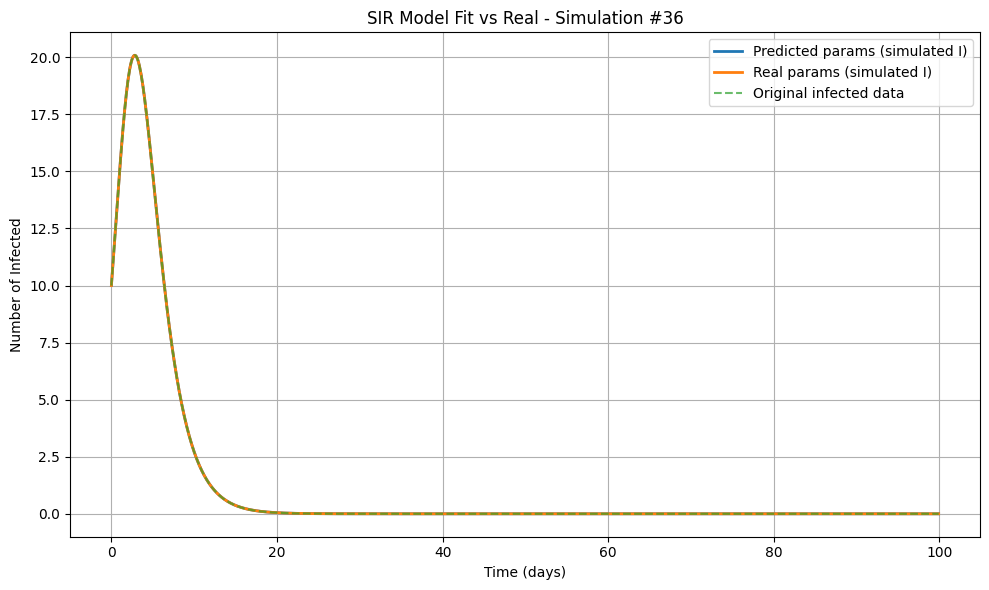

In [7]:
import matplotlib.pyplot as plt

# Example: simulation index to visualize
n_sim = 36

# True parameters
beta_real, gamma_real = y_test[n_sim]
# Estimated parameters
beta_pred, gamma_pred = y_pred[n_sim]

# Simulate using real and predicted parameters
solution_real_fit = simulate_SIR(beta_real, gamma_real)
solution_pred_fit = simulate_SIR(beta_pred, gamma_pred)

# Extract infected curves
I_real_model = solution_real_fit  # simulate_SIR returns only I
I_pred_model = solution_pred_fit
I_data = X_test[n_sim, :]  # Infected values from simulation (ground truth)

# Time vector (assume same as in model)
t = np.linspace(0, 100, len(I_data))
n_points = min(len(t), 1000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:n_points], I_pred_model[:n_points], '-', label='Predicted params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_real_model[:n_points], '-', label='Real params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_data[:n_points], '--', label='Original infected data', alpha=0.7)
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected')
plt.title(f'SIR Model Fit vs Real - Simulation #{n_sim}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparison: $\beta_{real}$ vs $\beta_{pred}$

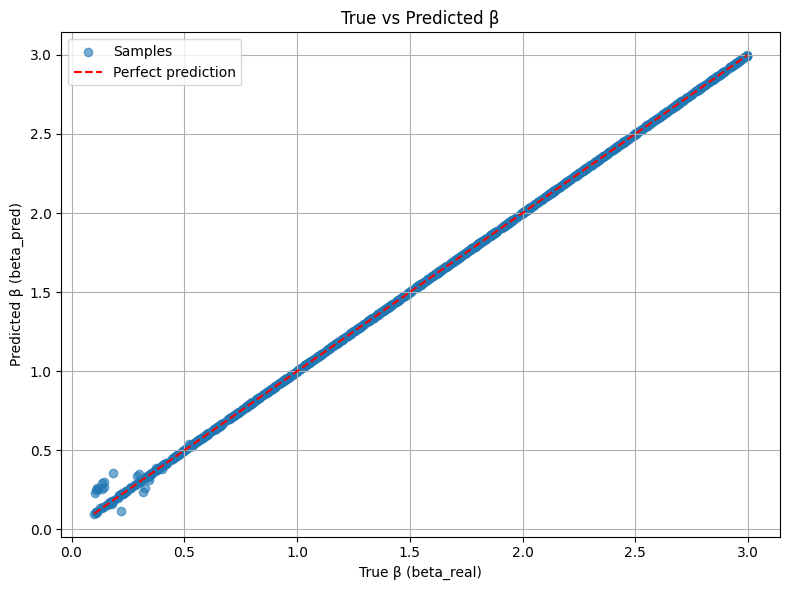

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract beta from predictions and true values
beta_real = y_test[:, 0]
beta_pred = y_pred[:, 0]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(beta_real, beta_pred, alpha=0.6, label='Samples')
plt.plot([beta_real.min(), beta_real.max()], [beta_real.min(), beta_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True β (beta_real)')
plt.ylabel('Predicted β (beta_pred)')
plt.title('True vs Predicted β')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparison: $\gamma_{real}$ vs $\gamma_{pred}$

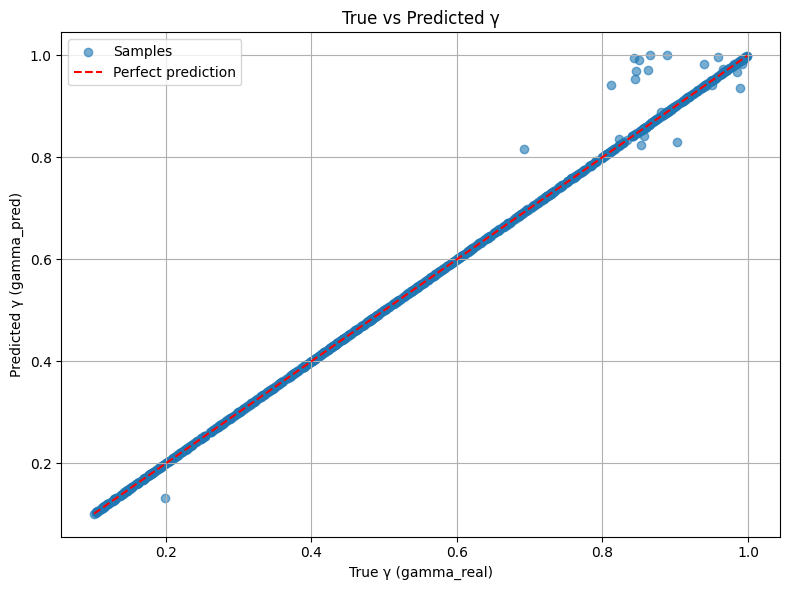

In [9]:
import matplotlib.pyplot as plt

# Extract gamma from predictions and true values
gamma_real = y_test[:, 1]
gamma_pred = y_pred[:, 1]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(gamma_real, gamma_pred, alpha=0.6, label='Samples')
plt.plot([gamma_real.min(), gamma_real.max()],
         [gamma_real.min(), gamma_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True γ (gamma_real)')
plt.ylabel('Predicted γ (gamma_pred)')
plt.title('True vs Predicted γ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()